# 신축에 따른 가격변화 추이

유의미한 가격 추이를 확인하지 못했음

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)

import module

In [3]:
df = module.file_load.load_origin_train()

In [7]:
df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [9]:

df[(df['아파트명']=='헬리오시티')][['target','계약년월','전용면적(㎡)']]

,target,계약년월,전용면적(㎡)
217189,262000,202210,110.44
217190,178500,202210,84.99
217191,179500,202210,84.99
217192,180000,202210,84.98
217193,186500,202210,84.95
...,...,...,...
427103,188900,201907,110.44
427104,97570,201907,39.86
427105,190470,201907,110.44
427106,151440,201907,84.97


In [5]:
module.preprocess.날짜포맷_add(df)

In [7]:
# 건축년도와 계약연도의 차이 계산
df['연수차'] = df['계약연도'].astype(int) - df['건축년도'].astype(int)


In [12]:
# 3년, 5년, 10년 기준으로 파생 변수 생성
def 구간분류(연수차):
    if 연수차 <= 3:
        return '3년 이내'
    elif 연수차 <= 5:
        return '3~5년'
    elif 연수차 <= 10:
        return '5~10년'
    elif 연수차 == 11:
        return '11년'
    else:
        return '10년 초과'

df['연수구간'] = df['연수차'].apply(구간분류)

In [13]:
# 결과 출력
print(df)

                   시군구     번지     본번    부번    아파트명  전용면적(㎡)    계약년월 계약일   층  \
0        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201712  08   3   
1        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201712  22   4   
2        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    54.98  201712  28   5   
3        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201801  03   4   
4        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201801  08   2   
...                ...    ...    ...   ...     ...      ...     ...  ..  ..   
1118817  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    59.94  200707  12  11   
1118818  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    59.94  200708  25  10   
1118819  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    84.83  200708  31  20   
1118820  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    84.83  200709  15   8   
1118821   서울특별시 중구 묵정동  11-67   11.0  67.0      묵정    52.46  200701  10   5   

         건축년도  ... 관리비 업로드         좌표X        좌표Y  

In [14]:
# 구간별 target 평균 분석
구간별_평균 = df.groupby('연수구간')['target'].mean().reset_index()

In [15]:
print("\n구간별 target 평균:")
print(구간별_평균)


구간별 target 평균:
     연수구간        target
0  10년 초과  57593.666983
1     11년  57238.519013
2    3~5년  61153.965186
3   3년 이내  61556.768219
4   5~10년  56754.325364


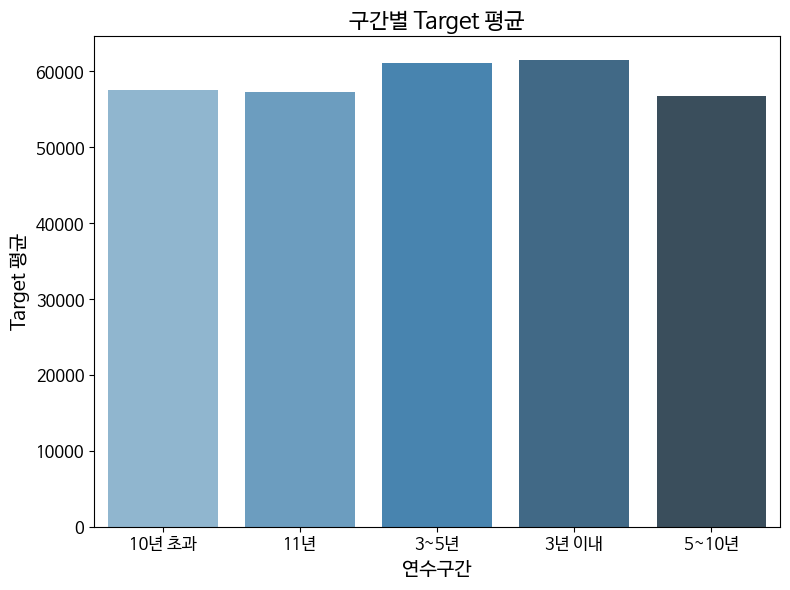

In [16]:

# 그래프 그리기
plt.figure(figsize=(8, 6))
sns.barplot(data=구간별_평균, x='연수구간', y='target', palette='Blues_d')

# 그래프 꾸미기
plt.title('구간별 Target 평균', fontsize=16)
plt.xlabel('연수구간', fontsize=14)
plt.ylabel('Target 평균', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 그래프 출력
plt.show()